# Astro R-CNN Demo

Simple example notebook of how to train and run inference Mask R-CNN on PhoSim data

In [17]:
import numpy as np
import matplotlib
from matplotlib.colors import LogNorm
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import time

# astro_rcnn
import astro_rcnn
from astro_rcnn import PhoSimDataset
from astro_rcnn import DESConfig
from astro_rcnn import InferenceConfig

# mrcnn
from mrcnn import visualize
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn import utils

# Seetup directories
ROOT_DIR = os.path.abspath("./Mask_RCNN")
TRAIN_DIR = os.path.abspath("./trainingset/") # training data
TEST_DIR = os.path.abspath("./testset/") # simulation of cluster of galaxies
VAL_DIR = os.path.abspath("./validationset/") # real data
REAL_DIR = os.path.abspath("./realset/") # simulation of cluster of galaxies


# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    
#model path
model_path = os.path.join(MODEL_DIR, "astro_rcnn_des.h5")


%matplotlib inline

## Create Models

In [9]:
## DATASET

# Training dataset
dataset_train = PhoSimDataset()
dataset_train.load_sources(TRAIN_DIR,"train")
dataset_train.prepare()

# Validation dataset
dataset_val = PhoSimDataset()
dataset_val.load_sources(VAL_DIR,"validation")
dataset_val.prepare()

# Test dataset
dataset_test = PhoSimDataset()
dataset_test.load_sources(TEST_DIR,"test")
dataset_test.prepare()

# Real dataset
dataset_real = PhoSimDataset()
dataset_real.load_sources(REAL_DIR,"real")
dataset_real.prepare()

## Training


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        300
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


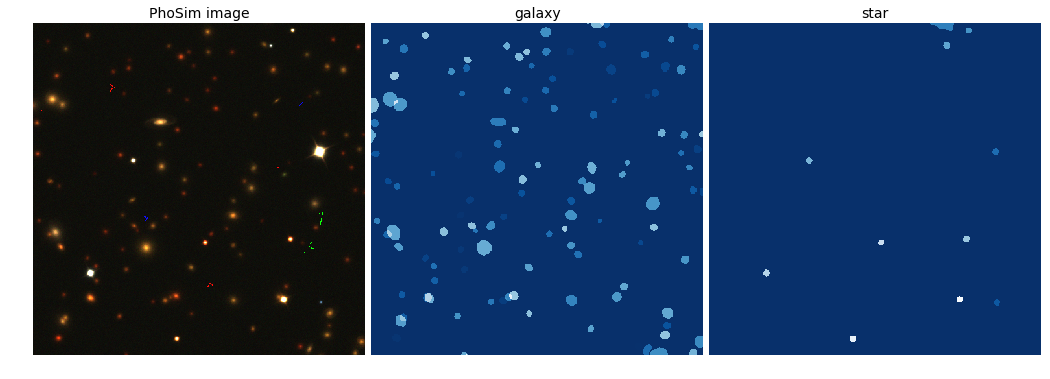

In [10]:
## Config
class TrainConfig(DESConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

train_config = TrainConfig()
train_config.display()

# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 1)
for image_id in image_ids:
    image = dataset_train.load_image(image_id,scale=False)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_val.class_names,save_fig=True)

## CREATE MODEL
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=train_config, model_dir=MODEL_DIR)

# Load weights trained on MS COCO, but skip layers that
# are different due to the different number of classes
# See README for instructions to download the COCO weights
model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=train_config.LEARNING_RATE,
            epochs=1,
            layers='heads')

# Fine tune all layers
# Passing layers="all" trains all layers. You can also
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=train_config.LEARNING_RATE / 10,
            epochs=2,
            layers="all")

# Save weights (uncomment to save)
#model.keras_model.save_weights(model_path)

## Detection

In [11]:
inference_config = InferenceConfig()
inference_config.display()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        300
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [18]:
# Test on a random image
"""
image_id = 2
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, 
                           image_id, use_mini_mask=False,scale=False)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names)
"""
# Test inference
start_time = time.time()
original_image_det, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, 
                           image_id, use_mini_mask=False,scale=True)

results = model.detect([original_image_det], verbose=1)

print("Done in %.2f sec." % float((time.time() - start_time)))
"""

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'],save_fig=True)
"""

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max: 65535.00000  uint16
molded_images            shape: (1, 512, 512, 3)      min: -444.00000  max: 65374.00000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
Done in 11.13 sec.


"\n\nr = results[0]\nvisualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], \n                            dataset_test.class_names, r['scores'],save_fig=True)\n"

## Real Image "Ground Truth" (SEXtractor)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


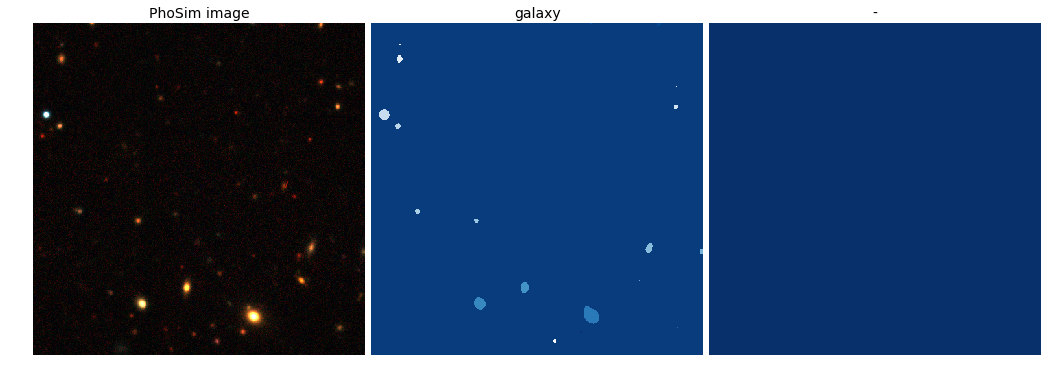

In [7]:
# Load and display random samples
image_ids = np.random.choice(dataset_real.image_ids, 1)
for image_id in image_ids:
    image = dataset_real.load_image(image_id,scale=False)
    mask, class_ids = dataset_real.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_real.class_names,save_fig=True)

## Real Image Inference

In [1]:
## Overwite default if desired
#class InferenceConfigReal(InferenceConfig):
#    DETECTION_NMS_THRESHOLD = .7
#    IMAGES_PER_GPU = 1
#    DETECTION_MIN_CONFIDENCE =.5
    
    
inference_config = InferenceConfig()
inference_config.display()
    
# Test on a random image
# Note: some images are too noisy to get a good result: 7,9
image_id = 22
# good images: 0, 14, 22, 23, 34
# nucleus in 24
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_real, inference_config, 
                           image_id, use_mini_mask=False,scale=False)

# Test inference
original_image_det, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_real, inference_config, 
                           image_id, use_mini_mask=False,scale=True)


results = model.detect([original_image_det], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'],save_fig=True)

NameError: name 'InferenceConfig' is not defined

In [53]:
# Plot examples of close pairs to check deblending capability
overlaps = []
boxes = []
masks = []
for ii,i in enumerate(r['rois']):
    xi1 = i[1]; xi2 = i[3]; yi1 = i[0]; yi2 = i[2]
    for ji,j in enumerate(r['rois']):
        # if both are galaxies
        if r['class_ids'][ii]==2 and r['class_ids'][ji]==2:
            # overlap (y1, x1, y2, x2)
            xj1 = j[1]; xj2 = j[3]; yj1 = j[0]; yj2 = j[2]
            xoverlap = ((xj1 > xi1 and xj1 < xi2) or (xj2 > xi1 and xj2 < xj2))
            yoverlap = ((yj1 > yi1 and yj1 < yi2) or (yj2 > yi1 and yj2 < yj2))
            if xoverlap and yoverlap:
                xcent = ((xj1+xj2)/2 + (xi1+xi2)/2)/2
                ycent = ((yj1+yj2)/2 + (yi1+yi2)/2)/2
                position = [int(np.round(xcent)),int(np.round(ycent))]
                if position not in overlaps:
                    overlaps.append(position)
                    boxes.append([r['rois'][ii],r['rois'][ji]])
                    masks.append([r['masks'][:,:,ii],r['masks'][:,:,ji]])
print(overlaps)

[]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: list index out of range

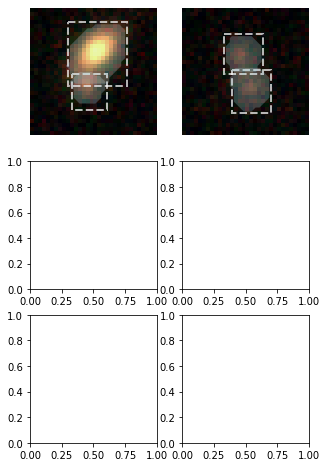

In [38]:
# Plot blends
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
fig,ax=plt.subplots(3,2,figsize=(5,8))
size = 16
for i,a in enumerate(ax.flatten()):
    # image
    xim1 = overlaps[i][0]-size; xim2 = overlaps[i][0]+size
    yim1 = overlaps[i][1]-size; yim2 = overlaps[i][1]+size
    xim1 = np.clip(xim1,0,original_image.shape[1])
    yim1 = np.clip(yim1,0,original_image.shape[0])
    a.imshow(original_image[yim1:yim2,xim1:xim2])
    # bbox
    box = boxes[i][0]
    x1 = box[1]-xim1; x2 = box[3]-xim1; y1 = box[0]-yim1; y2 = box[2]-yim1
    p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor="white", facecolor='none')
    a.add_patch(p)
    box = boxes[i][1]
    x1 = box[1]-xim1; x2 = box[3]-xim1; y1 = box[0]-yim1; y2 = box[2]-yim1
    p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor="white", facecolor='none')
    a.add_patch(p)
    # mask
    mask = masks[i][0][yim1:yim2,xim1:xim2]
    padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
    padded_mask[1:-1, 1:-1] = mask
    contours = visualize.find_contours(padded_mask, 0.5)
    for verts in contours:
        # Subtract the padding and flip (y, x) to (x, y)
        verts = np.fliplr(verts) - 1
        p = Polygon(verts, facecolor="lightblue", alpha = 0.25, edgecolor="none")
        a.add_patch(p)
    mask = masks[i][1][yim1:yim2,xim1:xim2]
    padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
    padded_mask[1:-1, 1:-1] = mask
    contours = visualize.find_contours(padded_mask, 0.5)
    for verts in contours:
        # Subtract the padding and flip (y, x) to (x, y)
        verts = np.fliplr(verts) - 1
        p = Polygon(verts, facecolor="lightblue", alpha = 0.25, edgecolor="none")
        a.add_patch(p)
    a.set_axis_off()
# plotting
fig.subplots_adjust(wspace=.01,hspace=.05,left=0.01,right=.99,bottom=.01,top=.99)
fig.savefig("blends.pdf")

image ID: des.4 (4) 
Original image shape:  [512 512   3]
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max: 65488.00000  uint16
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max: 65488.00000  uint16
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


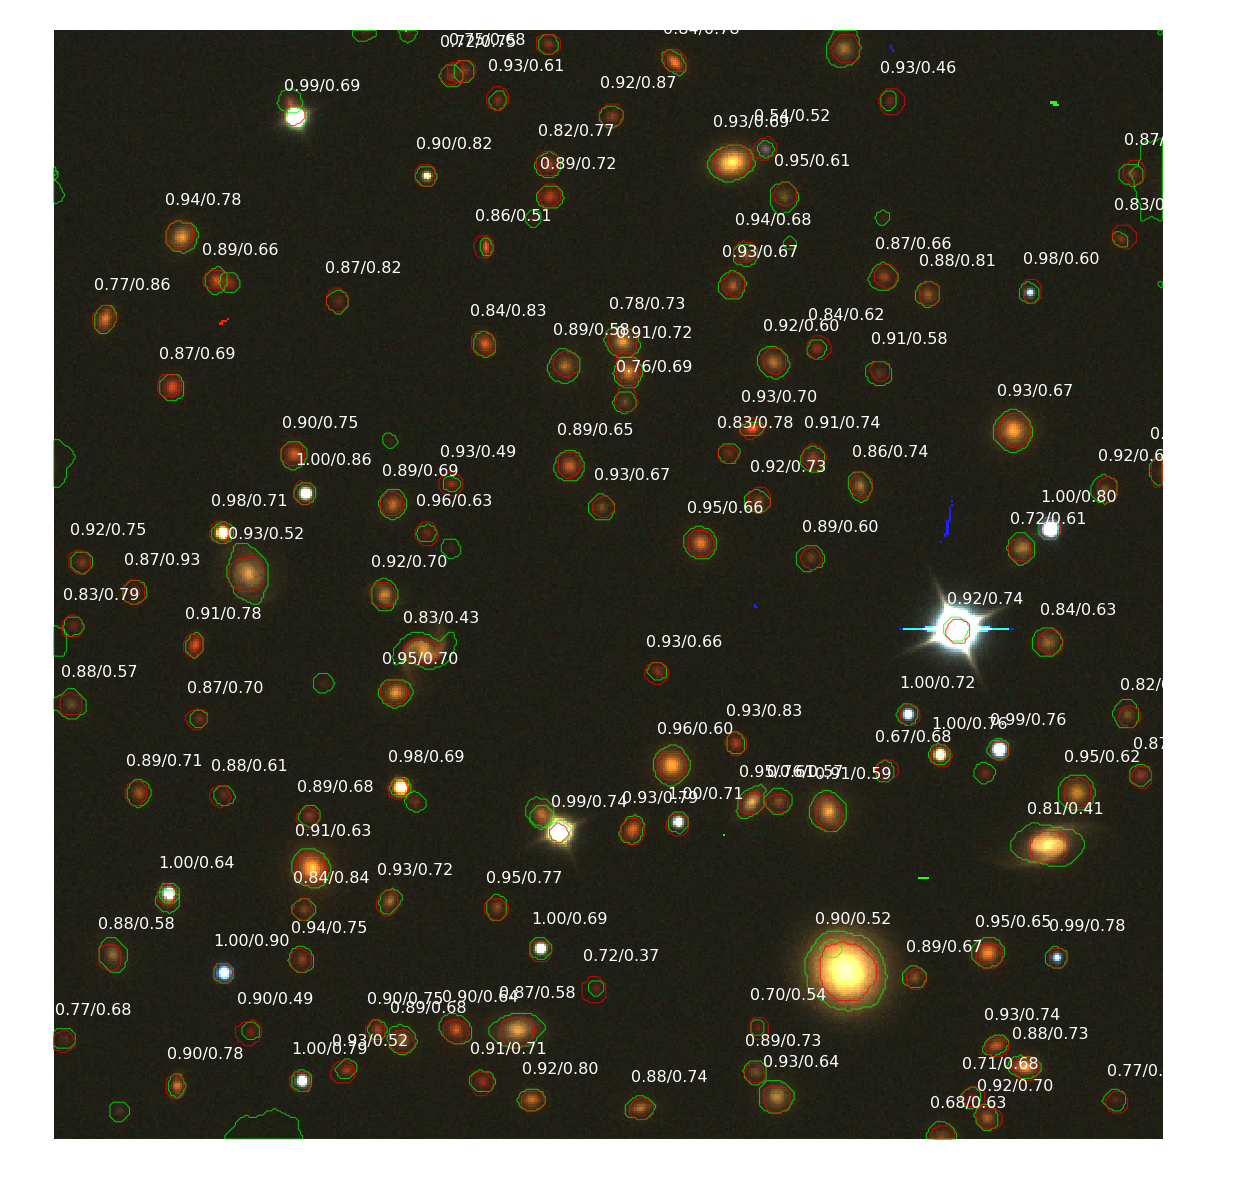

In [58]:
image_id = 4
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, image_id, use_mini_mask=False,scale=False)
image_det, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, image_id, use_mini_mask=False,scale=True)
info = dataset_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_test.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image_det, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset_test.class_names,
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.3, save_fig=True)

### Compute AP on Batch of Images


In [17]:
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_val, inference_config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 5
APs = compute_batch_ap(dataset_val, dataset_val.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [512 512   3]   AP: 0.29
  1 [512 512   3]   AP: 0.31
  2 [512 512   3]   AP: 0.35
  3 [512 512   3]   AP: 0.35
  4 [512 512   3]   AP: 0.36
Mean AP overa 5 images: 0.3309


## Evaluation

Mean AP score versus IOU thresholds for training set.

In [18]:
# Compute VOC-Style mAP
# May take a few minutes depending on size of validation set
def compute_performance(class_id=1,iou_threshold=0.5):
    APs = []
    ps = []
    rs = []
    for image_id in dataset_val.image_ids:
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_val, inference_config,
                                   image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        # match class
        i = np.where(r["class_ids"]==class_id)[0]
        j = np.where(gt_class_id==class_id)[0]
        # Compute AP
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox[j], gt_class_id[j], gt_mask[:,:,j],
                             r["rois"][i], r["class_ids"][i], r["scores"][i], r['masks'][:,:,i], iou_threshold=iou_threshold)

        APs.append(AP)
        # interpolate precisions and recalls to achieve same sampling for averaging
        precisions = np.interp(np.linspace(0, len(precisions), 50), np.arange(0, len(precisions)), precisions)
        recalls = np.interp(np.linspace(0, len(recalls), 50), np.arange(0, len(recalls)), recalls)
        ps.append(precisions)
        rs.append(recalls)
    print("mAP: ", np.mean(APs))
    return np.mean(APs), np.mean(ps,0), np.mean(rs,0)

In [ ]:
# Plot precision-recall curve over range of IOU thresholds
# This will take a while!
mean_APs_star = []
mean_ps_star = []
mean_rs_star = []
mean_APs_gal = []
mean_ps_gal = []
mean_rs_gal = []
iou_thresholds = np.arange(0.5, 1.0, 0.05)
for i in iou_thresholds:
    print(i)
    # star
    APs,ps,rs = compute_performance(1,i)
    mean_APs_star.append(APs)
    mean_ps_star.append(ps)
    mean_rs_star.append(rs)
    # galaxy
    APs,ps,rs = compute_performance(2,i)
    mean_APs_gal.append(APs)
    mean_ps_gal.append(ps)
    mean_rs_gal.append(rs)
    
visualize.plot_precision_recall_range(mean_APs_star,iou_thresholds,mean_ps_star,mean_rs_star,save_fig=True,title="star")
visualize.plot_precision_recall_range(mean_APs_gal,iou_thresholds,mean_ps_gal,mean_rs_gal,save_fig=True,title="galaxy")

0.5
mAP:  0.8422452561898902
mAP:  0.7523816478093692
0.55
mAP:  0.8312332512308784
mAP:  0.7126940460769291
0.6000000000000001
mAP:  0.7961427061828056
mAP:  0.6556609289918992
0.6500000000000001
mAP:  0.6576141650883818
mAP:  0.5540868888148534
0.7000000000000002
mAP:  0.4384383723154624
mAP:  0.4267009112029508
0.7500000000000002
mAP:  0.2476128463243965
mAP:  0.25478781783787424
0.8000000000000003
mAP:  0.09998105322400956
mAP:  0.11575325349356287
0.8500000000000003


## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

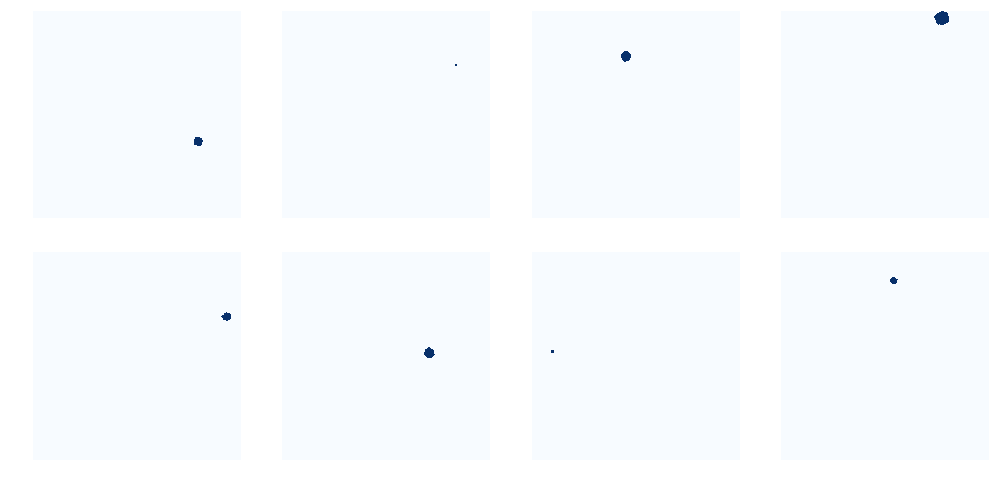

In [43]:
limit = 8
visualize.display_images(np.transpose(gt_mask[..., :limit], [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [44]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset_val.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    2.00000  float32
masks                    shape: (1, 100, 28, 28, 3)   min:    0.00000  max:    1.00000  float32
34 detections: ['star' 'star' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'star' 'galaxy' 'star'
 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy'
 'galaxy' 'galaxy' 'star' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy'
 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy' 'galaxy'
 'galaxy']


In [45]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (34, 28, 28)          min:    0.00000  max:    1.00000  float32
det_masks                shape: (34, 512, 512)        min:    0.00000  max:    1.00000  bool


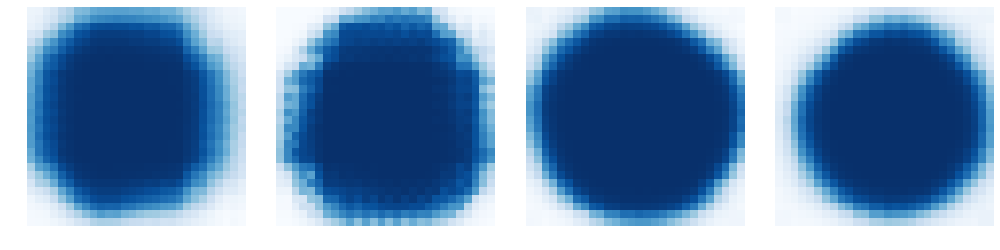

In [46]:
visualize.display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

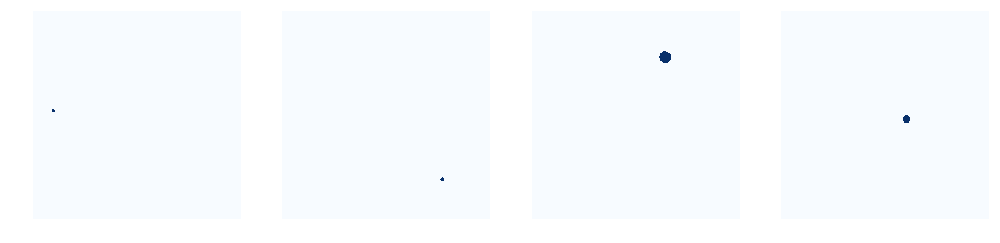

In [47]:
visualize.display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [15]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 512, 512, 3)      min: -114.70000  max: 65431.10156  float32
res2c_out                shape: (1, 128, 128, 256)    min:    0.00000  max: 5179.23242  float32
res3c_out                shape: (1, 64, 64, 512)      min:    0.00000  max: 4460.86768  float32
rpn_bbox                 shape: (1, 65472, 4)         min:  -37.22359  max:  161.21269  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


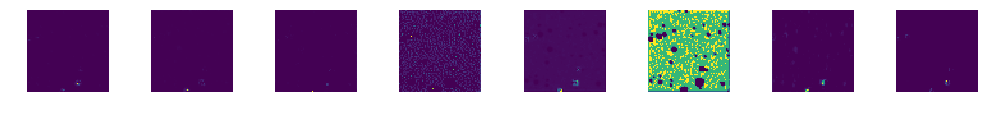

In [17]:
# Backbone feature map
visualize.display_images(np.transpose(activations["res3c_out"][0,:,:,0:8], [2, 0, 1]), cols=8)